### **Import Libraries and Download Files**

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
%%capture
! rm *
!wget https://raw.githubusercontent.com/spmallick/PyImageConf2018/master/faceBlendCommon.py -O /content/faceBlendCommon.py 
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml haarcascade_frontalface_default.xml -O /content/haarcascade_frontalface_default.xml
!wget https://cdn.cnn.com/cnnnext/dam/assets/170209140940-selena-gomez-full-169.jpg -O /content/test.jpg
#!wget https://image.shutterstock.com/image-photo/beauty-fashion-women-concept-gorgeous-260nw-1666349602.jpg -O /content/test.jpg
!wget https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat
!wget https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_vgg16.h5

import numpy as np
import pandas as pd
import sys
import cv2
import dlib
import numpy as np
import numpy as np
from PIL import Image
import shutil
from google.colab.patches import cv2_imshow
from google.colab import files
!pip install mediapipe
!pip3 install eos-py
!pip install face_recognition
import mediapipe as mp
from imutils import face_utils
import eos
from imageio import imread
from io import BytesIO
import IPython.display
import requests
from bs4 import BeautifulSoup
import time
from PIL import Image, ImageDraw
import face_recognition
from os.path import basename
import math
import pathlib
from pathlib import Path
import os
import random
import matplotlib.pyplot as plt
from skimage.draw import circle
import glob
import h5py
from PIL import ImageFile
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras import backend as K
import faceBlendCommon as fbc
from tensorflow.keras import layers
import tensorflow as tf


### **1. MODNet for Image Segmentation (Image Background Removal)**

Use the pre-trained MODNet model

In [12]:
# MODNet
import os

# clone the repository
%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/ZHKKKe/MODNet
%cd MODNet/

# dowload the pre-trained ckpt for image matting
pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz \
          -O pretrained/modnet_photographic_portrait_matting.ckpt

/content
/content/MODNet


Create input and output Repositories, and move the test image to the input repository.

In [13]:
input_folder = '/content/input'
if os.path.exists(input_folder):
  shutil.rmtree(input_folder)
os.makedirs(input_folder)

output_folder = '/content/output'
if os.path.exists(output_folder):
  shutil.rmtree(output_folder)
os.makedirs(output_folder)

In [14]:
shutil.move('/content/test.jpg', os.path.join(input_folder, 'test.jpg'))

'/content/input/test.jpg'

Run portrait matting command to remove the background, and save image in the output folder

In [15]:
## Remove Background
!python -m demo.image_matting.colab.inference \
        --input-path /content/input/ \
        --output-path /content/output/ \
        --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt

Process image: test.jpg
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


In [16]:
# https://livecodestream.dev/post/remove-the-background-from-images-using-ai-and-python/
image_name = 'test.jpg'
matte_name = image_name.split('.')[0] + '.png'
image = Image.open(os.path.join(input_folder, image_name))
matte = Image.open(os.path.join(output_folder, matte_name))

# calculate display resolution
w, h = image.width, image.height
rw, rh = 800, int(h * 800 / (3 * w))
  
# obtain predicted foreground
image = np.asarray(image)
if len(image.shape) == 2:
  image = image[:, :, None]
if image.shape[2] == 1:
  image = np.repeat(image, 3, axis=2)
elif image.shape[2] == 4:
  image = image[:, :, 0:3]
matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
foreground = image * matte + np.full(image.shape, 255) * (1 - matte)
  
# combine image, foreground, and alpha into one line
combined = np.concatenate((image, foreground, matte * 255), axis=1)
combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))

foreground = Image.fromarray(np.uint8(foreground)).resize((w, h))

foreground.save("/content/output/testNoBackground.jpg")


### **2. Crop to Face, Align, Rotate Image and Get Facial Measurements**

In [17]:
def transform(image_select):
  image = face_recognition.load_image_file(image_select)
  face_landmarks_list = face_recognition.face_landmarks(image)
  facial_features = ['chin','left_eyebrow','right_eyebrow','nose_bridge','nose_tip','left_eye','right_eye','top_lip','bottom_lip']
  pts = []
  for face_landmarks in face_landmarks_list:
    for facial_feature in facial_features:
        for point in  face_landmarks[facial_feature]:
          for pix in point:
            pts.append(pix)  
    eyes = []
    lex = pts[72]
    ley = pts[73]
    rex = pts[90]
    rey = pts[91]
    eyes.append(pts[72:74])
    eyes.append(pts[90:92])
    crop_image = crop_face(image, eye_left=(lex, ley), eye_right=(rex, rey), offset_pct=(0.34,0.34), dest_sz=(300,300))
    crop_image.save(str(image_select)+"_NEW_cropped.jpg")


Distance metric

In [18]:
def distance(p1,p2):
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    return math.sqrt(dx*dx+dy*dy)

Scale, rotate and translate

In [19]:
def scale_rotate_translate(image, angle, center = None, new_center = None, scale = None, resample=Image.BICUBIC):
    if (scale is None) and (center is None):
        return image.rotate(angle=angle, resample=resample)
    nx,ny = x,y = center
    sx=sy=1.0
    if new_center:
        (nx,ny) = new_center
    if scale:
        (sx,sy) = (scale, scale)
    cosine = math.cos(angle)
    sine = math.sin(angle)
    a = cosine/sx
    b = sine/sx
    c = x-nx*a-ny*b
    d = -sine/sy
    e = cosine/sy
    f = y-nx*d-ny*e
    image = Image.fromarray(image, 'RGB')
    return image.transform(image.size, Image.AFFINE, (a,b,c,d,e,f), resample=resample)

Crop to face

In [20]:
def crop_face(image, eye_left=(0,0), eye_right=(0,0), offset_pct=(0.3,0.3), dest_sz = (600,600)):
    # calculate offsets in original image
    offset_h = math.floor(float(offset_pct[0])*dest_sz[0])
    offset_v = math.floor(float(offset_pct[1])*dest_sz[1])
    # get the direction
    eye_direction = (eye_right[0] - eye_left[0], eye_right[1] - eye_left[1])
    # calc rotation angle in radians
    rotation = -math.atan2(float(eye_direction[1]),float(eye_direction[0]))
    #print(rotation)
    # distance between them
    dist = distance(eye_left, eye_right)
    # calculate the reference eye-width
    reference = dest_sz[0] - 2.0*offset_h
    # scale factor
    scale = float(dist)/float(reference)
    # rotate original around the left eye
    image = scale_rotate_translate(image, center=eye_left, angle=rotation)
    # crop the rotated image
    crop_xy = (eye_left[0] - scale*offset_h, eye_left[1] - scale*offset_v)
    crop_size = (dest_sz[0]*scale, dest_sz[1]*scale)
    image = image.crop((int(crop_xy[0]), int(crop_xy[1]), int(crop_xy[0]+crop_size[0]), int(crop_xy[1]+crop_size[1])))
    # resize it
    image = image.resize(dest_sz, Image.ANTIALIAS)
    return image

Identify landmark features

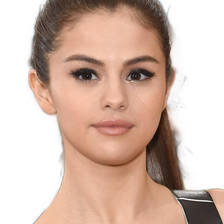

In [21]:
image_select = '/content/output/testNoBackground.jpg'
image = face_recognition.load_image_file(image_select)
face_landmarks_list = face_recognition.face_landmarks(image)
facial_features = ['chin','left_eyebrow','right_eyebrow','nose_bridge','nose_tip','left_eye','right_eye','top_lip','bottom_lip']
pts = []
for face_landmarks in face_landmarks_list:
  for facial_feature in facial_features:
      for point in  face_landmarks[facial_feature]:
        for pix in point:
          pts.append(pix)  
  eyes = []
  lex = pts[72]
  ley = pts[73]
  rex = pts[90]
  rey = pts[91]
  eyes.append(pts[72:74])
  eyes.append(pts[90:92])
  crop_image = crop_face(image, eye_left=(lex, ley), eye_right=(rex, rey), offset_pct=(0.34,0.34), dest_sz=(224,224))

crop_image

Identify new landmark features

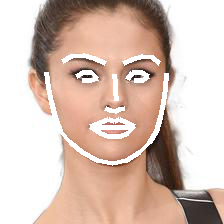

In [22]:
crop_image.save(str(image_select)+"_NEW_cropped.jpg")
nn = str(image_select)+"_NEW_cropped.jpg"
pts = []
face = 0
image = face_recognition.load_image_file(nn)
face_landmarks_list = face_recognition.face_landmarks(image)
facial_features = ['chin','left_eyebrow','right_eyebrow','nose_bridge','nose_tip','left_eye','right_eye','top_lip','bottom_lip']

pil_image = Image.fromarray(image)
d = ImageDraw.Draw(pil_image)

for face_landmarks in face_landmarks_list:
    # trace out each facial feature in the image with points
    for facial_feature in face_landmarks.keys():
      d.line(face_landmarks[facial_feature], width=5)
      d.point(face_landmarks[facial_feature], fill = (255,255,255))
    for facial_feature in facial_features:
      for  point in  face_landmarks[facial_feature]:
        for pix in point:
          pts.append(pix)

pil_image

In [23]:
from numpy import asarray
np.asarray(crop_image).shape

(224, 224, 3)

Plot all landmarks

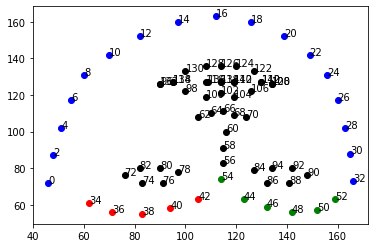

In [24]:
for i in range(0,34,2):
  plt.plot(pts[i], pts[i+1], 'bo', color='blue')
  plt.text(pts[i], pts[i+1], s=i)
for i in range(34,44,2):
  plt.plot(pts[i], pts[i+1], 'bo', color='red')
  plt.text(pts[i], pts[i+1], s=i)
for i in range(44,56,2):
  plt.plot(pts[i], pts[i+1], 'bo', color='green')
  plt.text(pts[i], pts[i+1], s=i)
for i in range(56,len(pts),2):
  plt.plot(pts[i], pts[i+1], 'bo', color='black')
  plt.text(pts[i], pts[i+1], s=i)

Manually identify points that correspond to major facial landmarks 

Measurements - facial width, facial height, facial width:facial height, jaw width, jaw width:face width

In [49]:
face_width = np.sqrt(np.square(pts[0] - pts[32]) + np.square( pts[1]  -  pts[33]))
face_height = np.sqrt(np.square(pts[16] - pts[56]) + np.square(pts[17] -  pts[57] )) * 2
height_to_width = face_height/face_width
jaw_width = np.sqrt(np.square(pts[12]-pts[20]) + np.square(pts[13]-pts[21]))
jaw_width_to_face_width = jaw_width/face_width
eye_brow_arch = (abs(pts[43]-pts[39])+abs(pts[53]-pts[49]))/2
lip_width = abs(pts[139]-pts[127])
eye_height = (abs(pts[75]-pts[81])+abs(pts[87]-pts[95]))/2
eye_width = (abs(pts[72]-pts[78])+abs(pts[84]-pts[90]))/2
eye_height_to_eye_width = eye_height/eye_width
nose_length = abs(pts[57]-pts[67])
nose_width = abs(pts[70]-pts[62])


face_width: 120.00416659433121
face_height: 160.11246047700348
height_to_width: 1.334224177550906
jaw_width: 57.0
jaw_width_to_face_width: 0.4749835078034081
eye_brow_arch: 7.5
lip_width: 9
eye_height: 8.0
eye_width: 21.0
eye_height_to_eye_width: 0.38095238095238093
nose_length: 28
nose_width: 19
Prediction: Straight


### **3. Set up the Celebrity Database to Classify Face Shape**

Image dataset

In [35]:
# Face shape: https://www.kaggle.com/niten19/face-shape-dataset/code
batch_size = 50
train_images = '/content/drive/MyDrive/Masters Notes/Winter2022/HairStyleTransfer/data/training_set'
test_images = '/content/drive/MyDrive/Masters Notes/Winter2022/HairStyleTransfer/data/testing_set'

In [51]:
vgg16 = '/content/rcmalli_vggface_tf_notop_vgg16.h5'

Run preprocessing on all images

In [ ]:
data_training = []

for r, d, f in os.walk(train_images):
    for file in f:
        if ".jpg" in file:
            data_training.append((os.path.join(r, file).split("/")[-2], os.path.join(r, file)))

df_training = pd.DataFrame(data_training, columns=['class','file_path'])


data_testing = []

for r, d, f in os.walk(test_images):
    for file in f:
        if ".jpg" in file:
            data_testing.append((os.path.join(r, file).split("/")[-2], os.path.join(r, file)))

df_testing = pd.DataFrame(data_testing, columns=['class','file_path'])

In [ ]:
for i in range(len(df_training)):
    transform(df_training['file_path'][i])

for i in range(len(df_testing)):
    transform(df_testing['file_path'][i])

In [36]:
data_training = []

for r, d, f in os.walk(train_images):
    for file in f:
        if "_NEW_cropped.jpg" in file:
            data_training.append((os.path.join(r, file).split("/")[-2], os.path.join(r, file)))

df_training = pd.DataFrame(data_training, columns=['class','file_path'])


data_testing = []

for r, d, f in os.walk(test_images):
    for file in f:
        if "_NEW_cropped.jpg" in file:
            data_testing.append((os.path.join(r, file).split("/")[-2], os.path.join(r, file)))

df_testing = pd.DataFrame(data_testing, columns=['class','file_path'])

In [38]:
df_training.head()

,class,file_path
0,Round,/content/drive/MyDrive/Masters Notes/Winter202...
1,Round,/content/drive/MyDrive/Masters Notes/Winter202...
2,Round,/content/drive/MyDrive/Masters Notes/Winter202...
3,Round,/content/drive/MyDrive/Masters Notes/Winter202...
4,Round,/content/drive/MyDrive/Masters Notes/Winter202...


In [39]:
TrainDatagen = ImageDataGenerator(
        preprocessing_function= preprocess_input,
        horizontal_flip = True)

TestDatagen = ImageDataGenerator(
    preprocessing_function= preprocess_input)

train_data = TrainDatagen.flow_from_dataframe(
    df_training, x_col='file_path',
    target_size = (224,224),
    batch_size =batch_size,
    class_mode = 'categorical')

test_data = TestDatagen.flow_from_dataframe(
    df_testing, x_col='file_path',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 3989 validated image filenames belonging to 5 classes.
Found 1009 validated image filenames belonging to 5 classes.


Define model architecture

In [54]:
# Loading VGG16 as base model
base_model = VGG16(input_shape=(224, 224, 3),  # same as our input
                   include_top=False,  # exclude the last layer
                   weights=vgg16)  # use VGGFace Weights
for layer in base_model.layers:
  layer.trainable = False

model_t1 = Sequential()

Build and compile the model

In [57]:
x = layers.Flatten()(base_model.output)

x = layers.Dense(64, activation='relu')(x)  # add 1 fully connected layer, try with 512 first 
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation='softmax')(x)  # add final layer

model_t1 = tf.keras.models.Model(base_model.input, x)

model_t1.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

model_t1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Fit the model

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
history = model_t1.fit(
    train_data,              
    steps_per_epoch = train_data.samples//batch_size,
    validation_data = test_data,
    validation_steps = test_data.samples//batch_size,
    epochs = 50,
    callbacks=[es,chkpt])

Save model and weights

In [ ]:
model_t1.save('face_shape_classifier.h5')
model_t1.save_weights('face_shape_classifier_weights.h5')

Predict shape of test image

In [ ]:
model_t1.predict(np.asarray(crop_image).reshape(-1, np.asarray(crop_image).shape[0], np.asarray(crop_image).shape[1], np.asarray(crop_image).shape[2]))

array([[0.19905712, 0.19444633, 0.20406768, 0.2046366 , 0.19779228]],
      dtype=float32)

Arg max

### **5. Hair Segmentation**

In [ ]:
# TODO
# https://github.com/gaelkt/HairNets/tree/5a4c7644ead58225d9d8d16bc83f1d6b9059f9b6


### **6. Get Hair Characteristics (Color, Length)**

In [ ]:
# TODO

# Hair type: https://www.kaggle.com/vyombhatia/the-three-hair-types

# Hair texture classification

### **7. Celebrity Database**

In [ ]:
# TODO